In [82]:
import numpy as np

class State:
    def __init__(self, vehicle_length, position, heading_angle, steering_angle, velocity, position_bounds=[[None, None], [None, None]], ang_bounds=[None, None], st_ang_bounds=[None, None], accel_bounds=[None, None], velocity_bounds=[None, None]):
        self.position       = position  # Center of front axle [x, y]
        self.heading_angle  = heading_angle
        self.steering_angle = steering_angle
        self.velocity = velocity

        self.position_bounds = position_bounds
        self.ang_bounds = ang_bounds
        self.st_ang_bounds = st_ang_bounds
        self.accel_bounds = accel_bounds
        self.velocity_bounds = velocity_bounds

        self.vehicle_length = vehicle_length

    @staticmethod
    def fromRawState(arr):
        return State(0, [arr[0], arr[1]], arr[2], arr[3], arr[4])
        
    def update(self, velocity, steering_rate, dT):
        """,
        [x, y, 𝜃, 𝛿], 𝜃 is heading angle, 𝛿 is steering angle. Our inputs are [𝑣, 𝜑], 𝑣 is velocity, 𝜑 is steering rate.

        x_dot = v * cos(𝛿 + 𝜃)
        y_dot = v * sin(𝛿 + 𝜃)
        𝜃_dot = v / R = v / (L/sin(𝛿)) = v * sin(𝛿)/L
        𝛿_dot = 𝜑
        """
        
        accel = velocity - self.velocity

        if self.accel_bounds[0] is not None:
            accel = max(self.accel_bounds[0], accel)
        if self.accel_bounds[1] is not None:
            accel = min(self.accel_bounds[1], accel)

        self.velocity += accel * dT

        if self.velocity_bounds[0] is not None:
            self.velocity = max(self.velocity_bounds[0], self.velocity)
        if self.velocity_bounds[1] is not None:
            self.velocity = min(self.velocity_bounds[1], self.velocity)

        self.steering_angle += steering_rate * dT

        if self.st_ang_bounds[0] is not None:
            self.steering_angle = max(self.st_ang_bounds[0], self.steering_angle)
        if self.st_ang_bounds[1] is not None:
            self.steering_angle = min(self.st_ang_bounds[1], self.steering_angle)

        heading_dot = velocity * np.sin(self.steering_angle) / self.vehicle_length
        self.heading_angle += heading_dot * dT

        if self.ang_bounds[0] is not None:
            self.heading_angle = max(self.ang_bounds[0], self.heading_angle)
        if self.ang_bounds[1] is not None:
            self.heading_angle = min(self.ang_bounds[1], self.heading_angle)

        x_dot = velocity * np.cos(self.heading_angle + self.steering_angle)
        y_dot = velocity * np.sin(self.heading_angle + self.steering_angle)

        self.position[0] += x_dot * dT
        self.position[1] += y_dot * dT

        # Enforce constraints
        if self.position_bounds[0][0] is not None:
            self.position[0] = max(self.position_bounds[0][0], self.position[0])
        if self.position_bounds[0][1] is not None:
            self.position[0] = min(self.position_bounds[0][1], self.position[0])
        if self.position_bounds[1][0] is not None:
            self.position[1] = max(self.position_bounds[1][0], self.position[1])
        if self.position_bounds[1][1] is not None:
            self.position[1] = min(self.position_bounds[1][1], self.position[1])

    def copy(self):
        return State(
            self.vehicle_length,
            self.position.copy(),
            self.heading_angle,
            self.steering_angle,
            self.velocity,
            self.position_bounds,
            self.ang_bounds,
            self.st_ang_bounds,
            self.accel_bounds,
            self.velocity_bounds
        )

    def updated_state(self, actions, dT):
        actions = np.reshape(actions, (-1, 2))
        new_state = self.copy()
        for i in actions:
            new_state.update(i[0], i[1], dT)

        return new_state

    def raw_state(self):
        return [self.position[0], self.position[1], self.heading_angle, self.steering_angle, self.velocity]

In [83]:
from scipy.optimize import minimize

class Optimizer:
    def __init__(self, initial_state, waypoints, waypoint_range, dT, N, per_state_cost_function, final_state_cost_function, goal, obstacles, input_bounds, additional_constraints=lambda x: 0):
        self.state = initial_state
        self.waypoints = waypoints
        self.state_cost = per_state_cost_function
        self.fstate_cost = final_state_cost_function
        self.obstacles = obstacles
        self.goal = goal
        self.dT = dT
        self.additional_constraints = additional_constraints
        self.input_bounds = input_bounds
        self.N = N
        self.waypoint_range = waypoint_range

    def cost(self, x):
        waypoint_weight = 1
        goal_weight = .5

        x = np.reshape(x, (self.N, 2))
        through_waypoint = float('inf')

        state = self.state.copy()

        dist_to_waypoint = ((state.position[0] - self.waypoints[0].position[0])**2 + (state.position[1] - self.waypoints[0].position[1])**2)**.5
        if dist_to_waypoint < through_waypoint:
            through_waypoint = dist_to_waypoint

        cost = 0

        for i in x:
            # if i[0] < 0:
            #    cost += 10 * i[0]

            state.update(i[0], i[1], self.dT)

            dist_to_waypoint = ((state.position[0] - self.waypoints[0].position[0])**2 + (state.position[1] - self.waypoints[0].position[1])**2)**.5
            if dist_to_waypoint < through_waypoint:
                through_waypoint = dist_to_waypoint

            for obstacle in self.obstacles:
                distance = ((state.position[0] - obstacle[0])**2 + (state.position[1] - obstacle[1])**2)**.5
                if distance < obstacle[2]:
                    cost += 10000000 * obstacle[2]/distance

        distance_to_goal = ((state.position[0] - self.goal.position[0])**2 + (state.position[1] - self.goal.position[1])**2)**.5
        cost += distance_to_goal * (goal_weight if through_waypoint < self.waypoint_range else 3 * goal_weight)
        cost += through_waypoint * (waypoint_weight if through_waypoint < self.waypoint_range else .1 * waypoint_weight)

            # cost += .2 * self.state_cost(state, self.obstacles, self.goal)
            # cost += 1 * self.state_cost(state, [], self.waypoints[0])
            
        # cost += .2 * self.state_cost(state, self.obstacles, self.goal) + self.fstate_cost(state, self.goal)
        # cost += 1 * self.state_cost(state, [], self.waypoints[0]) + .2 * self.fstate_cost(state, self.waypoints[0])

        return cost

    # def constraints(self, x):
    #     state = self.state.copy()
    #     x = np.reshape(x, (-1, 2))

    #     cost = 0
    #     for i in x:
    #         state.update(i[0], i[1], self.dT)
    #         cost += (not state.check_bounds() * 1)
    #         cost += state.check_obstacles(self.obstacles)

    #     return cost

    def calculate_optimal_input(self, initial_guess, N):
        # N actions
        # N+1 states
        # actions = np.array( [initial_guess for _ in range(N)] )
        actions = np.array(initial_guess)
        # actions = actions.flatten()

        bounds = []

        for _ in range(N):
            bounds.extend(self.input_bounds)
        
        # Minimize the cost function
        result = minimize(self.cost, actions, bounds=bounds)
        
        optimal_inputs = result.x
        return optimal_inputs

    

In [81]:
def dist(a: State, b):
    return ((a.position[0] - b[0])**2 + (a.position[1] - b[1])**2)**.5

def per_state_cost_function(state: State, obstacles, goal: State):
    cost = 0

    # Add cost for distance to goal
    x_dist = (goal.position[0] - state.position[0]) ** 2
    y_dist = (goal.position[1] - state.position[1]) ** 2

    cost += (x_dist + y_dist) ** .5

    # Add cost for bounds
    if state.position_bounds[0][0] is not None and state.position[0] < state.position_bounds[0][0]:
        cost += 100 * state.position_bounds[0][0] - state.position[0]
    if state.position_bounds[0][1] is not None and state.position[0] > state.position_bounds[0][1]:
        cost += 100 * state.position[0] - state.position_bounds[0][1]
    if state.position_bounds[1][0] is not None and state.position[1] < state.position_bounds[1][0]:
        cost += 100 * state.position_bounds[1][0] - state.position[1]
    if state.position_bounds[1][1] is not None and state.position[1] > state.position_bounds[1][1]:
        cost += 100 * state.position[1] - state.position_bounds[1][1]

    if state.ang_bounds[0] is not None and state.heading_angle < state.ang_bounds[0]:
        cost += 100 * state.ang_bounds[0] - state.heading_angle
    if state.ang_bounds[1] is not None and state.heading_angle > state.ang_bounds[1]:
        cost += 100 * state.heading_angle - state.ang_bounds[1]

    if state.st_ang_bounds[0] is not None and state.steering_angle < state.st_ang_bounds[0]:
        cost += 100 * state.st_ang_bounds[0] - state.steering_angle
    if state.st_ang_bounds[1] is not None and state.steering_angle > state.st_ang_bounds[1]:
        cost += 100 * state.steering_angle - state.st_ang_bounds[1]

    for obstacle in obstacles:
        distance = dist(state, obstacle)
        if distance <= obstacle[2]:
            cost += 10000000 * obstacle[2]/distance

    return cost

def final_state_cost_function(state, goal):
    cost = 0

    # Add cost for distance to goal
    x_dist = (goal.position[0] - state.position[0]) ** 2
    y_dist = (goal.position[1] - state.position[1]) ** 2

    cost += x_dist
    cost += y_dist
    
    # if goal.velx is not None:
    #     vx_dist = (goal.velx - state.velx) ** 2
    # else:
    #     vx_dist = 0

    # if goal.vely is not None:
    #     vy_dist = (goal.vely - state.vely) ** 2
    # else:
    #     vy_dist = 0

    return cost * 1000
    

In [94]:
# initial_state = State(0, 0, 0, 0, velx_bounds=(-5, 5), vely_bounds=(-5, 5))
# goal_state = State(5, 10, 0, 0, velx_bounds=(-5, 5), vely_bounds=(-5, 5))

# obstacles = [[2.5, 7.5, 1], [5.0, 3.0, 1], [3.0, 3.0, 1], [7.5, 7.5, 1]]
# waypoints = [[2, 5, None, None], [4, 6, None, None], [goal_state.x, goal_state.y, goal_state.velx, goal_state.vely]]
# dT = .1
# N = 30

# optimizer = Optimizer(initial_state, [], dT, per_state_cost_function, final_state_cost_function, goal_state, obstacles, (-3, 3))
# optimal_inputs = optimizer.calculate_optimal_input([2/dT/N, 5/dT/N], N)

initial_state = State(
    vehicle_length=1,
    position=[0, 0],
    heading_angle=0,
    steering_angle=0,
    velocity=0,
    position_bounds=[[-10, 10], [-10, 10]],
    ang_bounds=[None, None],
    st_ang_bounds=[-np.pi/2, np.pi/2],
    accel_bounds=[-2, 3],
    velocity_bounds=[-2, 3]
)

goal_state = State(
    vehicle_length=1,
    position=[5, 5],
    heading_angle=0,
    steering_angle=0,
    velocity=0,
    position_bounds=[[-10, 10], [-10, 10]],
    ang_bounds=[None, None],
    st_ang_bounds=[-np.pi/2, np.pi/2],
    accel_bounds=[-4, 6],
    velocity_bounds=[-2, 3]
)

obstacles = [[2, 2.5, 1], [3, 1, 1], [3.5, 3.5, 1], [2.5, 4.5, 1]]
waypoints = [[.8, 3, None, None, None], [1.2, 5, None, None, None], [3, 6, None, None, None], [4, 5, None, None, None], [goal_state.position[0], goal_state.position[1], None, None, goal_state.velocity]]

# waypoints = [[goal_state.position[0], goal_state.position[1], None, None]]

dT = .1
N = 10

# optimizer = Optimizer(initial_state, waypoints, dT, per_state_cost_function, final_state_cost_function, goal_state, obstacles, [[-3, 3], [-np.pi/4, np.pi/4]])
# optimal_inputs = optimizer.calculate_optimal_input([2/dT/N, 0], N)

In [97]:
import numpy as np
import time

time_spent = 0
iters_spent = 0

range_ = .5
final_range_ = .1

total_inputs = []
rest_of_them = []

kept_states = 4

state = initial_state.copy()

def within_range(state, waypoint, range_):
    dist_ = ((waypoint[0] - state.position[0])**2 + (waypoint[1] - state.position[1])**2)**.5

    return dist_ <= range_

waypoints_copy = waypoints.copy()

while len(waypoints_copy) > 0:
    start_time = time.time()
    optimizer = Optimizer(state.copy(), [State.fromRawState(way) for way in waypoints_copy], range_, dT, N, per_state_cost_function, final_state_cost_function, goal_state, obstacles, [[0, 6], [-np.pi/2, np.pi/2]])
    # optimal_inputs = optimizer.calculate_optimal_input([2/dT/N, 0], N)

    # print("INITIAL INPUT: ", [current_to_waypoint_needed_velocity, current_to_waypoint_needed_steering_angle])

    starting_inputs = []

    if len(rest_of_them) > 0:
        starting_inputs = list(rest_of_them)

        emulated_state = state.updated_state(starting_inputs, dT)

        current_to_waypoint_vector = np.array([waypoints_copy[0][0] - emulated_state.position[0], waypoints_copy[0][1] - emulated_state.position[1]])

        current_to_waypoint_needed_accel = (np.linalg.norm(current_to_waypoint_vector) - emulated_state.velocity) / dT / N
        current_to_waypoint_needed_steering_angle = (np.arctan2(current_to_waypoint_vector[1], current_to_waypoint_vector[0]) - emulated_state.heading_angle) / dT / N

        for _ in range(N - int(len(rest_of_them) / 2)):
            # starting_inputs.extend(rest_of_them[-2], 0)
            starting_inputs.extend([current_to_waypoint_needed_accel, current_to_waypoint_needed_steering_angle])
    else:
        # Set initial velocity and angle based on next waypoint
        current_to_waypoint_vector = np.array([waypoints_copy[0][0] - state.position[0], waypoints_copy[0][1] - state.position[1]])

        current_to_waypoint_needed_accel = (np.linalg.norm(current_to_waypoint_vector) - state.velocity) / dT / N
        current_to_waypoint_needed_steering_angle = (np.arctan2(current_to_waypoint_vector[1], current_to_waypoint_vector[0]) - state.heading_angle) / dT / N

        for _ in range(N):
            starting_inputs.extend([current_to_waypoint_needed_accel, current_to_waypoint_needed_steering_angle])

    optimal = optimizer.calculate_optimal_input(
        starting_inputs,
        N
    )

    optimal_inputs = optimal[:kept_states * 2]
    rest_of_them = optimal[kept_states * 2:]

    # time.sleep(2)
    # optimal_inputs = optimizer.calculate_optimal_input(
    #     [0, 0],
    #     N
    # )[:16]
    end_time = time.time()

    time_spent += end_time - start_time
    iters_spent += 1

    total_inputs.extend(optimal_inputs)
    state = state.updated_state(optimal_inputs, dT)

    # print(state.raw_state())

    if len(waypoints_copy) > 1:
        if within_range(state, waypoints_copy[0], range_):
            # print("WITHIN RANGE")
            if within_range(state, waypoints_copy[-1], final_range_):
                break
            waypoints_copy.pop(0)
    else:
        if within_range(state, waypoints_copy[0], final_range_):
            break

print(total_inputs)
print("FINAL STATE: ", state.raw_state())
print("AVG TIME: ", time_spent / iters_spent)

[3.1899792194091368, 0.8422282367177506, 3.174862763355618, 0.8730585756081048, 3.1542602012876637, 0.9147135610732148, 3.1287824197213485, 0.9657326441021717, 3.0997314761526034, 1.0238425801554003, 3.0692265250553614, 1.0859090301246865, 3.040114371892122, 1.1480211839742718, 3.015571679844315, 1.2057728133172312, 2.9873773977183125, 1.231246128427367, 2.9763002172759325, 1.2805251574811638, 0.0, 0.31173985925457526, 0.0, 0.31173985925457526, 0.0, 0.2879704420034669, 0.0, 0.2879704420034669, 0.0, 0.2879704420034669, 0.0, 0.2879704420034669, 0.0, 0.16827118762520077, 0.0, 0.16827118762520077, 0.0, 0.17524085268536238, 0.0, 0.18216442685078266, 0.0, -0.07037633224887078, 0.0, -0.06478266587729657, 0.0, -0.059756608725544814, 0.0, -0.032550569551732, 0.0, -0.32578152956703854, 0.0, -0.29920152219307344, 0.0, -0.25998654178357394, 0.0, -0.21073927111159918, 0.0, -0.7245805383257047, 0.0, -0.627513290011738, 0.0, -0.5676210074427013, 0.0, -0.4898151298567254, 0.0, -1.5137020227911566, 0.0

[[0, 0, 0, 0, 0], [0.317032702943717, 0.03535448298055194, 0.026835153667244913, 0.08422282367177507, 0.30000000000000004], [0.6244473927714465, 0.1146876043079118, 0.08102650383838665, 0.17152868123258558, 0.5874862763355619], [0.9116785312990408, 0.2450403842338301, 0.1630305179053419, 0.26300003733990707, 0.8441636688307721], [1.1639945500429418, 0.4300523324555629, 0.2731245041449963, 0.35957330175012425, 1.0726255439198298], [1.363105383178258, 0.6676196458020589, 0.4112799487815787, 0.46195755976566427, 1.2753361371431071], [1.4891527103087852, 0.9474652924437101, 0.5770469455863595, 0.570548462778133, 1.4547251759343325], [1.524331888135758, 1.2494344620442979, 0.7694693033807121, 0.6853505811755601, 1.6132640955301114], [1.4578858097828724, 1.5435800794420638, 0.9870347920931484, 0.8059278625072832, 1.7534948539615318], [1.2930237136942027, 1.7927080113108782, 1.2263395902063936, 0.9290524753500199, 1.87688310833721], [1.0471995821859745, 1.960499924708971, 1.4855564514277382, 

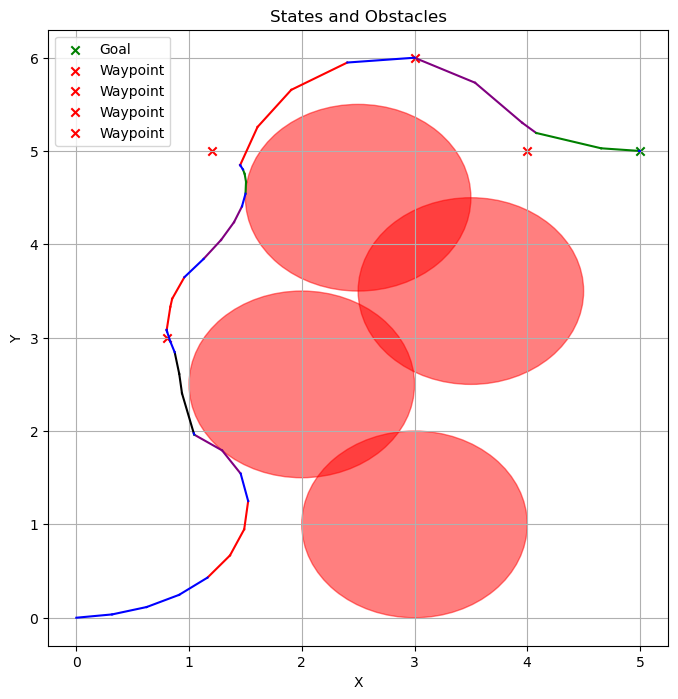

In [98]:
import matplotlib.pyplot as plt

# Calculate optimal inputs
new_actions = np.reshape(total_inputs, (-1, 2))

# current_to_waypoint_needed_velocity = np.linalg.norm(current_to_waypoint_vector) / dT / N
# current_to_waypoint_needed_steering_angle = np.arctan2(current_to_waypoint_vector[1], current_to_waypoint_vector[0]) / dT / N

# new_actions = np.reshape([3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016], (-1, 2))

state = initial_state.copy()
states = [state.raw_state()]
real_states = []
for action in new_actions:
    real_states.append(state.copy())
    state.update(action[0], action[1], dT)
    states.append(state.raw_state())

real_states.append(state.copy())

print(states)
print(real_states)

x = [state[0] for state in states]
y = [state[1] for state in states]

# Split x into a list of lists with 4 elements each
x_new = [x[i:i + 4] for i in range(0, len(x), kept_states)]
y_new = [y[i:i + 4] for i in range(0, len(y), kept_states)]

# Plot states and obstacles, drawing every 4 states with new colors
plt.figure(figsize=(8, 8))

for obstacle in obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='red', alpha=0.5)
    plt.gca().add_patch(circle)

# Plot the goal
plt.scatter(goal_state.position[0], goal_state.position[1], color='green', marker='x', label='Goal')

# Plot the waypoints
for waypoint in waypoints[:-1]:
    plt.scatter(waypoint[0], waypoint[1], color='red', marker='x', label='Waypoint')

print(waypoints)

# Plot lines between states
# for i in range(len(x) - 1):
#     plt.plot([x[i], x[i+1]], [y[i], y[i+1]], color='blue')

colors = ["blue", "red", "purple", "green", "black"]

for i in x_new:
    for j in range(len(i) - 1):
        plt.plot([i[j], i[j+1]], [y_new[x_new.index(i)][j], y_new[x_new.index(i)][j+1]], color=colors[x_new.index(i)%len(colors)])

# Add a line between each set of states
for i in range(len(x_new) - 1):
    plt.plot([x_new[i][-1], x_new[i+1][0]], [y_new[i][-1], y_new[i+1][0]], color='blue')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('States and Obstacles')
plt.legend()
plt.grid(True)
plt.show()

# # Animate a vehicle moving along the path of states in 'real_states'
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation

# fig, ax = plt.subplots()
# ax.set_xlim(-10, 10)
# ax.set_ylim(-10, 10)
# line, = ax.plot([], [], 'o-')

# def init():
#     line.set_data([], [])
#     return line, 

# def animate(i):
#     line.set_data(real_states[i].position[0], real_states[i].position[1])
#     return line,

# ani = animation.FuncAnimation(fig, animate, frames=len(real_states), init_func=init, blit=True)

# Save animation to file
# ani.save('vehicle_animation.gif', writer='imagemagick', fps=10)

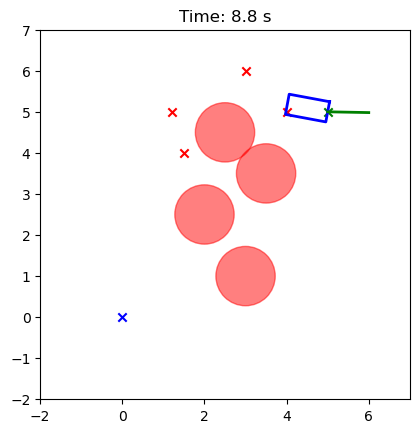

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, ImageMagickWriter

# Function to draw a car based on its state
def draw_car(ax, state):
    car_length = state.vehicle_length
    car_width = 0.5 * car_length
    # Draw obstacles
    for obstacle in obstacles:
        circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2]-car_width/1.8, color='red', alpha=0.5)
        ax.add_patch(circle)

    # Draw the goal
    ax.scatter(goal_state.position[0], goal_state.position[1], color='green', marker='x', label='Goal')

    # Draw the waypoints
    for waypoint in waypoints[:-1]:
        ax.scatter(waypoint[0], waypoint[1], color='red', marker='x', label='Waypoint')

    # Draw the initial state
    ax.scatter(initial_state.position[0], initial_state.position[1], color='blue', marker='x', label='Initial State')

    # Find top left corner. We know that the state.position is in the center of the front axle
    # Rotate 90 degrees counterclockwise from state.heading_angle and extend a vector from state.position by car_width/2
    top_left = [
        state.position[0] - (0.5 * car_width * np.sin(state.heading_angle)), 
        state.position[1] + (0.5 * car_width * np.cos(state.heading_angle))
    ]

    # Top right corner
    top_right = [
        state.position[0] + (0.5 * car_width * np.sin(state.heading_angle)), 
        state.position[1] - (0.5 * car_width * np.cos(state.heading_angle))
    ]

    # Bottom right corner
    bottom_right = [
        top_right[0] - car_length * np.cos(state.heading_angle),
        top_right[1] - car_length * np.sin(state.heading_angle)
    ]

    # Bottom left corner
    bottom_left = [
        top_left[0] - car_length * np.cos(state.heading_angle),
        top_left[1] - car_length * np.sin(state.heading_angle)
    ]

    # Draw the car as a rectangle
    ax.plot([top_left[0], top_right[0], bottom_right[0], bottom_left[0], top_left[0]], [top_left[1], top_right[1], bottom_right[1], bottom_left[1], top_left[1]], color='blue', linewidth=2)

    # Draw a vector representing the heading angle
    # ax.plot([state.position[0], state.position[0] + car_length * np.cos(state.heading_angle)], [state.position[1], state.position[1] + car_length * np.sin(state.heading_angle)], color='red', linewidth=2)

    # Draw a vector representing the steering angle
    ax.plot(
        [state.position[0], state.position[0] + car_length * np.cos(state.heading_angle + state.steering_angle)], 
        [state.position[1], state.position[1] + car_length * np.sin(state.heading_angle + state.steering_angle)], 
        color='green', linewidth=2
    )

# Function to update the plot for each frame of the animation
def update(frame):
    ax.clear()
    ax.set_xlim(-2, 7)
    ax.set_ylim(-2, 7)
    ax.set_aspect('equal')
    ax.set_title(f'Time: {round(frame * dT, 2)} s')

    draw_car(ax, real_states[frame])

# List of states for each time step
# states = real_states  # Populate this with your list of states

# Create a figure and axis
fig, ax = plt.subplots()

# Create the animation
ani = FuncAnimation(fig, update, frames=len(states), interval=dT * 1000)

# Set up the writer for saving the animation as a GIF
writer = ImageMagickWriter(fps=int(1/dT))

# Save the animation as a GIF
ani.save('cars_animation.gif', writer=writer)

plt.show()